# interpret static embedding

In [1]:
from pathlib import Path
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm
import torch
from ruamel.yaml import YAML
mpl.rcParams['figure.dpi'] = 150

In [2]:
# data_dir = Path('data/')
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [3]:
%load_ext autoreload
%autoreload 2

# Code

In [4]:
print([d.name for d in (data_dir / "runs/").iterdir()])
print([d.name for d in (data_dir / "runs/ealstm_less_vars_2004_1607_1334").glob("*")])

(data_dir / "runs/ealstm_less_vars_2004_1607_1334")
(data_dir / "runs/lstm_less_vars_2004_1507_1028")

['ealstm_less_vars_2004_1607_1334', 'lstm_less_vars_1307_1717', 'ealstm_less_vars_2004_1707_1424', 'lstm_less_vars_2004_1507_1028']
['config.yml', 'events.out.tfevents.1594906656.GPU_MachineLearning.22441.0', 'model_epoch001.pt', 'model_epoch002.pt', 'model_epoch003.pt', 'model_epoch004.pt', 'model_epoch005.pt', 'model_epoch006.pt', 'model_epoch007.pt', 'model_epoch008.pt', 'model_epoch009.pt', 'model_epoch010.pt', 'model_epoch011.pt', 'valid_ds.nc', 'results_ealstm_less_vars_2004_1607_1334_E002.csv', 'results_ealstm_less_vars_2004_1607_1334_E006.csv', 'model_epoch012.pt', 'results_ealstm_less_vars_2004_1607_1334_E007.csv', 'results_ealstm_less_vars_2004_1607_1334_E001.csv', 'results_ealstm_less_vars_2004_1607_1334_E008.csv', 'results_ealstm_less_vars_2004_1607_1334_E009.csv', 'results_ealstm_less_vars_2004_1607_1334_E010.csv', 'model_epoch013.pt', 'results_ealstm_less_vars_2004_1607_1334_E005.csv', 'results_ealstm_less_vars_2004_1607_1334_E004.csv', 'results_ealstm_less_vars_2004_1607

PosixPath('/cats/datastore/data/runs/lstm_less_vars_2004_1507_1028')

In [109]:
import sys
sys.path.insert(1, '/home/tommy/tommy_multiple_forcing')

from codebase.modelzoo.ealstm import EALSTM
from codebase.modelzoo.cudalstm import CudaLSTM
from codebase.data.camelstxt import CamelsGBCSV
from codebase.data.utils import load_basin_file
from codebase.data.camelsh5 import CamelsGBH5
from codebase.data.hdf5utils import create_h5_file
from codebase.config import parse_config
from codebase.errors import NoTrainDataError

## Load in config file

In [5]:
# Config file
config_path = (data_dir / "runs/ealstm_less_vars_2004_1607_1334/config.yml") 
yaml = YAML(typ="safe")      
cfg = yaml.load(config_path)
cfg = parse_config(cfg)

In [44]:
assert (data_dir / "CAMELS_GB_DATASET").exists()
# assert (data_dir / "runs/lstm_less_vars_2004_1507_1028/train_data/train_data_scaler.p").exists()
# assert (data_dir / "runs/lstm_less_vars_2004_1507_1028/train_data/train_data.h5").exists()
assert (data_dir / "runs/train_data_scaler.p").exists()
assert (data_dir / "runs/train_data.h5").exists()
assert Path('/home/tommy/tommy_multiple_forcing/data/camels_gb_basin_list.txt').exists()

cfg["data_dir"] = data_dir / "CAMELS_GB_DATASET"
cfg["scaler_file"] = data_dir / "runs/train_data_scaler.p"
cfg["h5_file"] = data_dir / "runs/train_data.h5"
cfg["train_basin_file"] = Path('/home/tommy/tommy_multiple_forcing/data/camels_gb_basin_list.txt')
# input_size_dyn = len(cfg["dynamic_inputs"])
# input_size_stat = len(cfg["static_inputs"] + cfg["camels_attributes"])

## Extra Processes

In [45]:
# Create new .h5 dataset and new .p scaler object
if False:
    fname = cfg["scaler_file"].name
    parents = cfg["scaler_file"].parents[2]
    new_scaler_file = parents / fname

    fname = cfg["h5_file"].name
    parents = cfg["h5_file"].parents[2]
    new_h5_file = parents / fname

    create_h5_file(
        basins=basins,
        cfg=cfg,
        h5_file=new_h5_file,
        scaler_file=new_scaler_file,
    )

In [46]:
if False:
    # load in the attributes (static data)
    h5 = CamelsGBH5(cfg)
    attributes = h5._load_attributes()
    # means = attributes.mean()
    # stds = attributes.std()

# Create Model Embeddings

In [121]:
# Initialize model
model = EALSTM(cfg)
model.load_state_dict(torch.load(model_path, map_location="cpu"))

# # extract weight and bias of input gate
# weight = model.lstm.weight_sh
# bias = model.lstm.bias_s

# # model information
# input_size_dyn = len(cfg["dynamic_inputs"])
# input_size_stat = len(cfg["static_inputs"] + cfg["camels_attributes"])

<All keys matched successfully>

In [125]:
basins = load_basin_file(Path(cfg["train_basin_file"]))
# mode = train validation test
mode = "test"
# scaler 
with open(cfg["scaler_file"], "rb") as fp:
    scaler = pickle.load(fp)
scaler["camels_attr_mean"]

EMBEDDING_FILE = config_path.parents[0] / "EMBEDDINGS.pkl"
if not (EMBEDDING_FILE).exists():
    # CALCULATE EMBEDDINGS
    ignore_basins = []
    all_embeddings = []
    for basin in tqdm(basins):
        try: 
            ds_test = CamelsGBCSV(
                    basin=basin,
                    cfg=cfg,
                    mode=mode,
                    scaler=scaler,
            )

            # get static weights/biases
            static_weights, static_bias = [p for p in model.input_net.parameters()]

            # CALCULATE the input gate embeddings
            # input_gate = torch.sigmoid(torch.addmm(static_bias, ds_test.attributes, static_weights))
            input_gate = torch.sigmoid(model.input_net(ds_test.attributes))
            embedding = input_gate.detach().numpy()
            all_embeddings.append(embedding)

        except NoTrainDataError:
            print(f"{basin} has no training data")
            ignore_basins.append(basin)

    all_embeddings = np.array(all_embeddings)
    embed_dict = {"embeddings": all_embeddings, "missing_basins": ignore_basins, "all_basins": basins}
    with EMBEDDING_FILE.open("wb") as fp:
        pickle.dump(embed_dict, fp)
    
else:
    # LOAD EMBEDDINGS
    with EMBEDDING_FILE.open("rb") as fp:
        embed_dict = pickle.load(fp)
        
        
all_embeddings = embed_dict["embeddings"]
ignore_basins = embed_dict["missing_basins"]
all_basins = embed_dict["all_basins"]

Each column corresponds to one basin and the rows denote the input gate value of the **`n hidden`** LSTM cells. The basins are ordered by ascending CAMELS GB gauge id.

Text(0, 0.5, 'Activation')

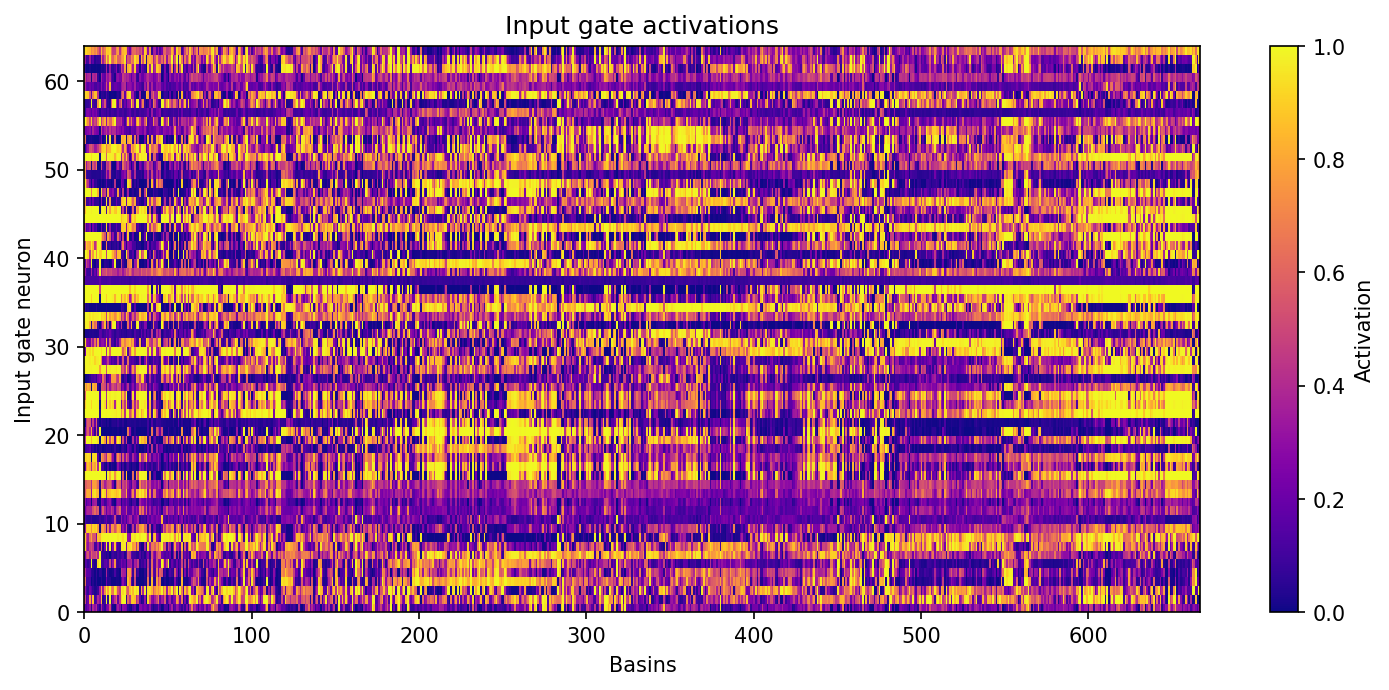

In [127]:
fig, ax = plt.subplots(figsize=(12,5))
img = ax.pcolor(all_embeddings.T, cmap='plasma')
ax.set_xlabel("Basins")
ax.set_ylabel("Input gate neuron")
ax.set_title("Input gate activations")
cbar = plt.colorbar(img, ax=ax)
cbar.ax.set_ylabel("Activation")

# Interpret Static Embeddings